# Predicting Car Crash Severity for South Australia

In [82]:
import os.path
import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import jaccard_score

import seaborn as sns

import itertools

from sklearn import metrics
mpl.style.use('ggplot') # optional: for ggplot-like style

# 1. Load dataset

In [83]:
# Initiate empty dataframe.
dfcrash = pd.DataFrame()

# Load 2012 - 2019 data into dataframe
for fyear in range(2012, 2020):
    fname = 'sadata\\'+str(fyear)+'_DATA_SA_Crash.csv'

    if(os.path.isfile(fname)): 
        dfcrash = dfcrash.append(pd.read_csv(fname),ignore_index=True)
        print('Loaded file:',fname, dfcrash.shape)

Loaded file: sadata\2012_DATA_SA_Crash.csv (22829, 33)
Loaded file: sadata\2013_DATA_SA_Crash.csv (39504, 33)
Loaded file: sadata\2014_DATA_SA_Crash.csv (55666, 33)
Loaded file: sadata\2015_DATA_SA_Crash.csv (71097, 33)
Loaded file: sadata\2016_DATA_SA_Crash.csv (87872, 33)
Loaded file: sadata\2017_DATA_SA_Crash.csv (101109, 33)
Loaded file: sadata\2018_DATA_SA_Crash.csv (114708, 33)
Loaded file: sadata\2019_DATA_SA_Crash.csv (127672, 33)


In [84]:
dfcrash.head()

,REPORT_ID,Stats Area,Suburb,Postcode,LGA Name,Total Units,Total Cas,Total Fats,Total SI,Total MI,...,Crash Type,Unit Resp,Entity Code,CSEF Severity,Traffic Ctrls,DUI Involved,Drugs Involved,ACCLOC_X,ACCLOC_Y,UNIQUE_LOC
0,2012-1-21/08/2019,2 Metropolitan,STEPNEY,5069,"CC OF NORWOOD,PAYNEHAM & ST PETERS",2,0,0,0,0,...,Right Angle,2,Driver Rider,1: PDO,No Control,NaN,NaN,1330659.71,1671795.87,1.330660e+13
1,2012-2-21/08/2019,2 Metropolitan,PARKSIDE,5063,CITY OF UNLEY,2,0,0,0,0,...,Hit Parked Vehicle,1,Driver Rider,1: PDO,No Control,NaN,NaN,1329400.16,1668462.66,1.329400e+13
2,2012-3-21/08/2019,2 Metropolitan,SELLICKS BEACH,5174,CITY OF ONKAPARINGA,3,0,0,0,0,...,Other,1,Driver Rider,1: PDO,No Control,NaN,NaN,1313748.22,1624241.28,1.313748e+13
3,2012-4-21/08/2019,2 Metropolitan,HINDMARSH,5007,CITY OF CHARLES STURT,2,0,0,0,0,...,Rear End,2,Driver Rider,1: PDO,Stop Sign,NaN,NaN,1325326.77,1672425.55,1.325327e+13
4,2012-5-21/08/2019,2 Metropolitan,HINDMARSH,5007,CITY OF CHARLES STURT,2,0,0,0,0,...,Rear End,1,Driver Rider,1: PDO,Traffic Signals,NaN,NaN,1326056.45,1673028.42,1.326056e+13


# 2. Data Cleaning

## 2.1 Drop non-relevant Columns

In [85]:
dfcrash.columns

Index(['REPORT_ID', 'Stats Area', 'Suburb', 'Postcode', 'LGA Name',
       'Total Units', 'Total Cas', 'Total Fats', 'Total SI', 'Total MI',
       'Year', 'Month', 'Day', 'Time', 'Area Speed', 'Position Type',
       'Horizontal Align', 'Vertical Align', 'Other Feat', 'Road Surface',
       'Moisture Cond', 'Weather Cond', 'DayNight', 'Crash Type', 'Unit Resp',
       'Entity Code', 'CSEF Severity', 'Traffic Ctrls', 'DUI Involved',
       'Drugs Involved', 'ACCLOC_X', 'ACCLOC_Y', 'UNIQUE_LOC'],
      dtype='object')

In [ ]:
# Cross Table of DUI Involved vs Severity
cb = pd.crosstab(dfcrash['DUI Involved'],dfcrash['CSEF Severity'])
cb.plot(kind='bar',figsize=(8,4),rot=0)

In [ ]:
# Cross Table of Drugs Involved vs Severity
cb = pd.crosstab(dfcrash['Drugs Involved'],dfcrash['CSEF Severity'])
cb.plot(kind='bar',figsize=(8,4),rot=0)

In [86]:
# drop non-relevant data
dp_col = ['REPORT_ID', 'Stats Area', 'Suburb', 'Postcode', 
       'Total Fats', 'Total SI', 'Total MI','LGA Name',
       'Year', 'Month', 'Day', 'Time', 'Unit Resp','UNIQUE_LOC',
       'Entity Code','DUI Involved','Drugs Involved','ACCLOC_X',
       'ACCLOC_Y']
dfcrash.drop(columns=dp_col,inplace=True)
dfcrash.shape

(127672, 14)

In [87]:
# no null values
dfcrash.isnull().sum()

Total Units         0
Total Cas           0
Area Speed          0
Position Type       0
Horizontal Align    0
Vertical Align      0
Other Feat          0
Road Surface        0
Moisture Cond       0
Weather Cond        0
DayNight            0
Crash Type          0
CSEF Severity       0
Traffic Ctrls       0
dtype: int64

In [88]:
dfcrash.dtypes

Total Units          int64
Total Cas            int64
Area Speed           int64
Position Type       object
Horizontal Align    object
Vertical Align      object
Other Feat          object
Road Surface        object
Moisture Cond       object
Weather Cond        object
DayNight            object
Crash Type          object
CSEF Severity       object
Traffic Ctrls       object
dtype: object

In [89]:
dfcrash.head()

,Total Units,Total Cas,Area Speed,Position Type,Horizontal Align,Vertical Align,Other Feat,Road Surface,Moisture Cond,Weather Cond,DayNight,Crash Type,CSEF Severity,Traffic Ctrls
0,2,0,60,Not Divided,Straight road,Level,Driveway or Entrance,Sealed,Dry,Not Raining,Daylight,Right Angle,1: PDO,No Control
1,2,0,40,Not Divided,Straight road,Level,Not Applicable,Sealed,Dry,Not Raining,Daylight,Hit Parked Vehicle,1: PDO,No Control
2,3,0,100,Not Divided,Straight road,Slope,Not Applicable,Sealed,Dry,Not Raining,Daylight,Other,1: PDO,No Control
3,2,0,60,T-Junction,Straight road,Level,Not Applicable,Sealed,Dry,Not Raining,Daylight,Rear End,1: PDO,Stop Sign
4,2,0,60,T-Junction,Straight road,Level,Not Applicable,Sealed,Dry,Not Raining,Daylight,Rear End,1: PDO,Traffic Signals


In [90]:
dfcrash.columns

Index(['Total Units', 'Total Cas', 'Area Speed', 'Position Type',
       'Horizontal Align', 'Vertical Align', 'Other Feat', 'Road Surface',
       'Moisture Cond', 'Weather Cond', 'DayNight', 'Crash Type',
       'CSEF Severity', 'Traffic Ctrls'],
      dtype='object')

In [91]:
# Formatting
dfcrash['Total Units'] = dfcrash['Total Units'].astype('uint8')
dfcrash['Total Cas'] = dfcrash['Total Cas'].astype('uint8')

for col in ['Area Speed', 'Position Type','Horizontal Align', 'Vertical Align', 'Other Feat', 'Road Surface',
       'Moisture Cond', 'Weather Cond', 'DayNight', 'Crash Type','CSEF Severity', 'Traffic Ctrls']:
    dfcrash[col] = dfcrash[col].astype('category')
dfcrash.dtypes

Total Units            uint8
Total Cas              uint8
Area Speed          category
Position Type       category
Horizontal Align    category
Vertical Align      category
Other Feat          category
Road Surface        category
Moisture Cond       category
Weather Cond        category
DayNight            category
Crash Type          category
CSEF Severity       category
Traffic Ctrls       category
dtype: object

In [92]:
# dfcrash for categories data, dfcrash_org for original data
dfcrash_org = dfcrash.copy()

In [93]:
dfcrash_org

,Total Units,Total Cas,Area Speed,Position Type,Horizontal Align,Vertical Align,Other Feat,Road Surface,Moisture Cond,Weather Cond,DayNight,Crash Type,CSEF Severity,Traffic Ctrls
0,2,0,60,Not Divided,Straight road,Level,Driveway or Entrance,Sealed,Dry,Not Raining,Daylight,Right Angle,1: PDO,No Control
1,2,0,40,Not Divided,Straight road,Level,Not Applicable,Sealed,Dry,Not Raining,Daylight,Hit Parked Vehicle,1: PDO,No Control
2,3,0,100,Not Divided,Straight road,Slope,Not Applicable,Sealed,Dry,Not Raining,Daylight,Other,1: PDO,No Control
3,2,0,60,T-Junction,Straight road,Level,Not Applicable,Sealed,Dry,Not Raining,Daylight,Rear End,1: PDO,Stop Sign
4,2,0,60,T-Junction,Straight road,Level,Not Applicable,Sealed,Dry,Not Raining,Daylight,Rear End,1: PDO,Traffic Signals
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127667,2,1,60,Cross Road,Straight road,Level,Not Applicable,Sealed,Dry,Not Raining,Daylight,Rear End,2: MI,Traffic Signals
127668,2,0,50,Not Divided,Straight road,Level,Not Applicable,Sealed,Dry,Not Raining,Night,Hit Parked Vehicle,1: PDO,No Control
127669,2,1,50,Not Divided,Straight road,Slope,Driveway or Entrance,Sealed,Dry,Not Raining,Daylight,Side Swipe,2: MI,No Control
127670,2,0,50,Not Divided,Straight road,Level,Not Applicable,Sealed,Dry,Not Raining,Daylight,Other,1: PDO,No Control


In [95]:

# Columns for Backup Categories
cat_col =['Area Speed','Area Speed Cat','Position Type','Position Type Cat',
       'Horizontal Align','Horizontal Align Cat', 'Vertical Align','Vertical Align Cat',
       'Other Feat','Other Feat Cat', 'Road Surface', 'Road Surface Cat',
       'Moisture Cond','Moisture Cond Cat', 'Weather Cond','Weather Cond Cat', 'DayNight','DayNight Cat',
       'Crash Type','Crash Type Cat','CSEF Severity','CSEF Severity Cat', 'Traffic Ctrls', 'Traffic Ctrls Cat']

# New empty dataframe for backup categories
dfcat = pd.DataFrame(columns = cat_col)

# Backup Categories and encoded values
for icol in range(0,len(cat_col),2):
    codes, cats = pd.factorize(dfcrash[cat_col[icol]].unique())     # get category Code
    dfcat[cat_col[icol]] = pd.Series(cats)                          # Backup Categories
    if(cat_col[icol+1] != 'CSEF Severity Cat') :
        dfcrash[cat_col[icol]] = dfcrash[cat_col[icol]].cat.codes   # Convert Categories to num
        dfcat[cat_col[icol+1]] = pd.Series(codes)                   # Backup Categories code
    else:
        # Severity Code
        dfcrash[cat_col[icol]] = dfcrash[cat_col[icol]].cat.codes+1 # match Severity Code to original one
        dfcat[cat_col[icol+1]] = pd.Series(codes)+1                 # match Severity Code to original one

In [96]:
dfcrash.head()

,Total Units,Total Cas,Area Speed,Position Type,Horizontal Align,Vertical Align,Other Feat,Road Surface,Moisture Cond,Weather Cond,DayNight,Crash Type,CSEF Severity,Traffic Ctrls
0,2,0,8,6,2,2,3,0,0,0,0,9,1,1
1,2,0,6,6,2,2,5,0,0,0,0,4,1,1
2,3,0,12,6,2,3,5,0,0,0,0,7,1,1
3,2,0,8,14,2,2,5,0,0,0,0,8,1,8
4,2,0,8,14,2,2,5,0,0,0,0,8,1,9


In [97]:
print(dfcrash.dtypes)
print(dfcrash.shape)

Total Units         uint8
Total Cas           uint8
Area Speed           int8
Position Type        int8
Horizontal Align     int8
Vertical Align       int8
Other Feat           int8
Road Surface         int8
Moisture Cond        int8
Weather Cond         int8
DayNight             int8
Crash Type           int8
CSEF Severity        int8
Traffic Ctrls        int8
dtype: object
(127672, 14)


# 3. Data Understanding

## 3.1 Feature Distribution per categories

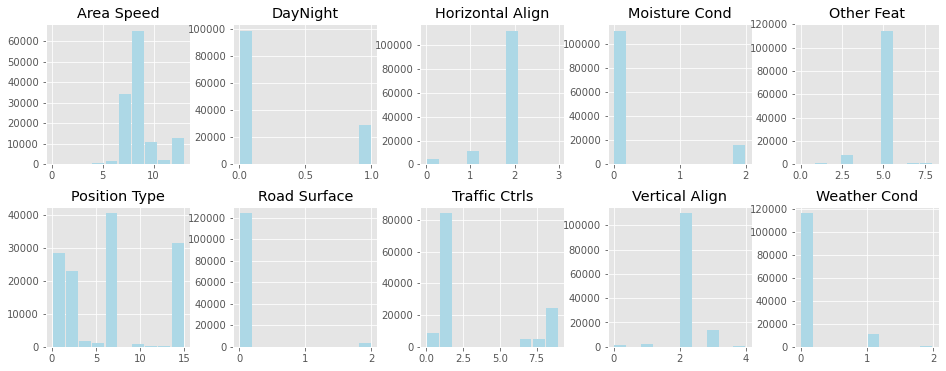

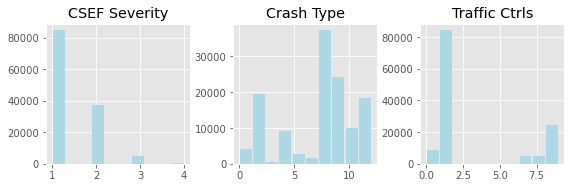

In [98]:
# Feature Distribution per categories
v = dfcrash[['Area Speed', 'Position Type','Horizontal Align', 'Vertical Align', 'Other Feat', 
             'Road Surface','Moisture Cond', 'Weather Cond', 'DayNight', 'Traffic Ctrls']]
v.hist(layout=(5,5),figsize=(16,16),rwidth=0.9,color='lightblue')
v = dfcrash[['Crash Type','Traffic Ctrls','CSEF Severity']]
v.hist(layout=(5,5),figsize=(16,16),rwidth=0.9,color='lightblue')
plt.show()

##  3.2 Features vs Severity 

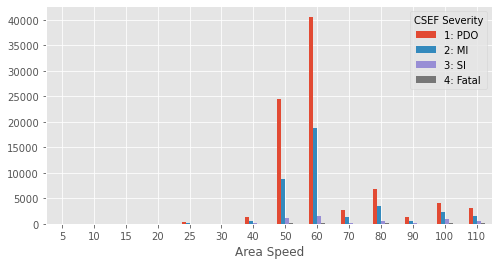

In [99]:
# Cross Table of Area Speed vs Severity
cb = pd.crosstab(dfcrash_org['Area Speed'],dfcrash_org['CSEF Severity'])
cb.plot(kind='bar',figsize=(8,4),rot=0)

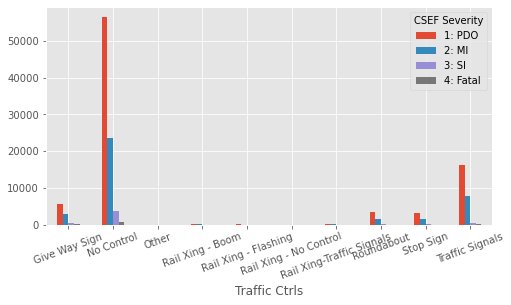

In [100]:
# Cross Table of Traffic Ctrls vs Severity
cb = pd.crosstab(dfcrash_org['Traffic Ctrls'],dfcrash_org['CSEF Severity'])
cb.plot(kind='bar',figsize=(8,4),rot=20)

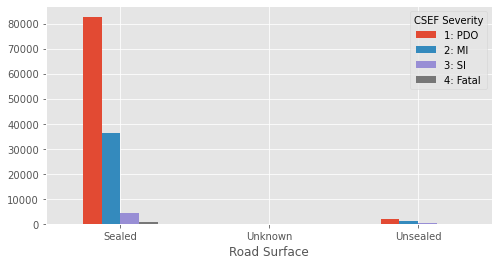

In [101]:
# Cross Table of Road Surface vs Severity
cb = pd.crosstab(dfcrash_org['Road Surface'],dfcrash_org['CSEF Severity'])
cb.plot(kind='bar',figsize=(8,4),rot=0)

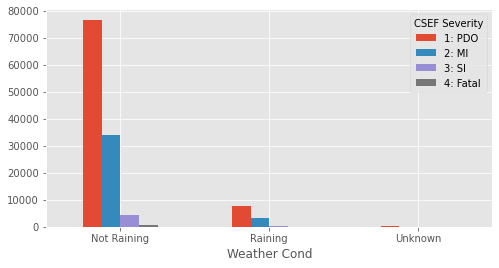

In [102]:
# Cross Table of Weather Cond vs Severity
cb = pd.crosstab(dfcrash_org['Weather Cond'],dfcrash_org['CSEF Severity'])
cb.plot(kind='bar',figsize=(8,4),rot=0)

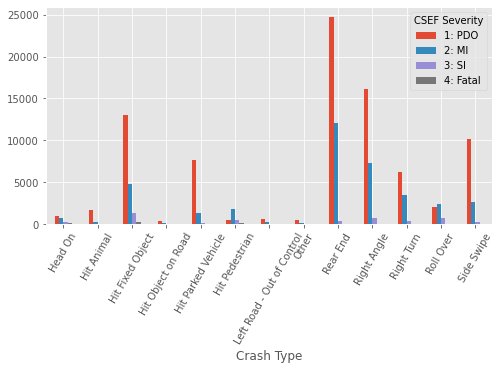

In [103]:
# Cross Table of Crash Type vs Severity
cb = pd.crosstab(dfcrash_org['Crash Type'],dfcrash_org['CSEF Severity'])
cb.plot(kind='bar',figsize=(8,4),rot=60)

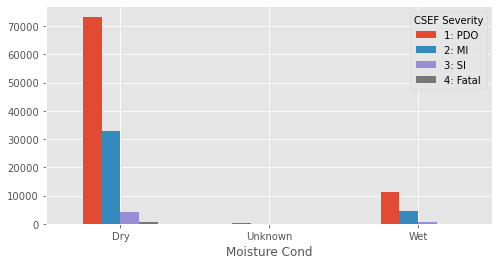

In [104]:
# Cross Table of Moisture Cond vs Severity
cb = pd.crosstab(dfcrash_org['Moisture Cond'],dfcrash_org['CSEF Severity'])
cb.plot(kind='bar',figsize=(8,4),rot=0)

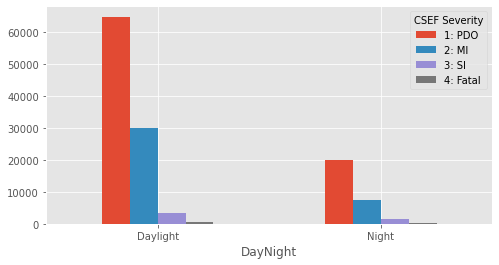

In [105]:
# Cross Table of DayNight vs Severity
cb = pd.crosstab(dfcrash_org['DayNight'],dfcrash_org['CSEF Severity'])
cb.plot(kind='bar',figsize=(8,4),rot=0)

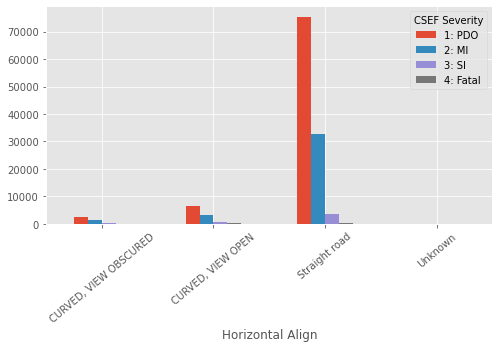

In [106]:
# Cross Table of Horizontal Align vs Severity
cb = pd.crosstab(dfcrash_org['Horizontal Align'],dfcrash_org['CSEF Severity'])
cb.plot(kind='bar',figsize=(8,4),rot=40)

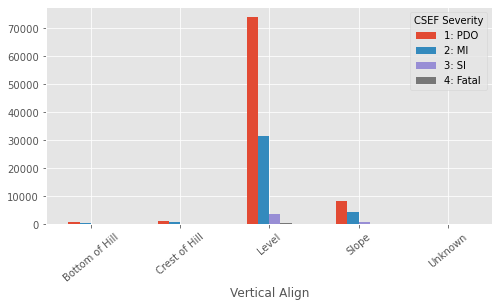

In [107]:
# Cross Table of Vertical Align vs Severity
cb = pd.crosstab(dfcrash_org['Vertical Align'],dfcrash_org['CSEF Severity'])
cb.plot(kind='bar',figsize=(8,4),rot=40)

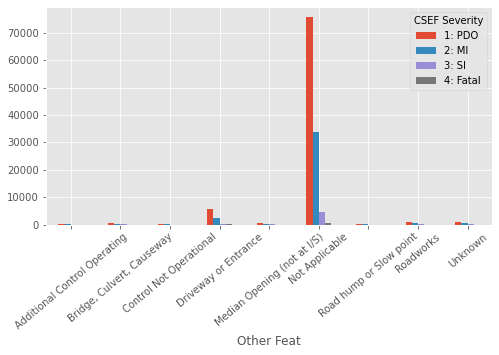

In [108]:
# Cross Table of Other Feat vs Severity
cb = pd.crosstab(dfcrash_org['Other Feat'],dfcrash_org['CSEF Severity'])
cb.plot(kind='bar',figsize=(8,4),rot=40)

## 3.3 Pearson Correlation

In [109]:
# Pearson Correlation
crash_pearson = dfcrash.corr(method='pearson')

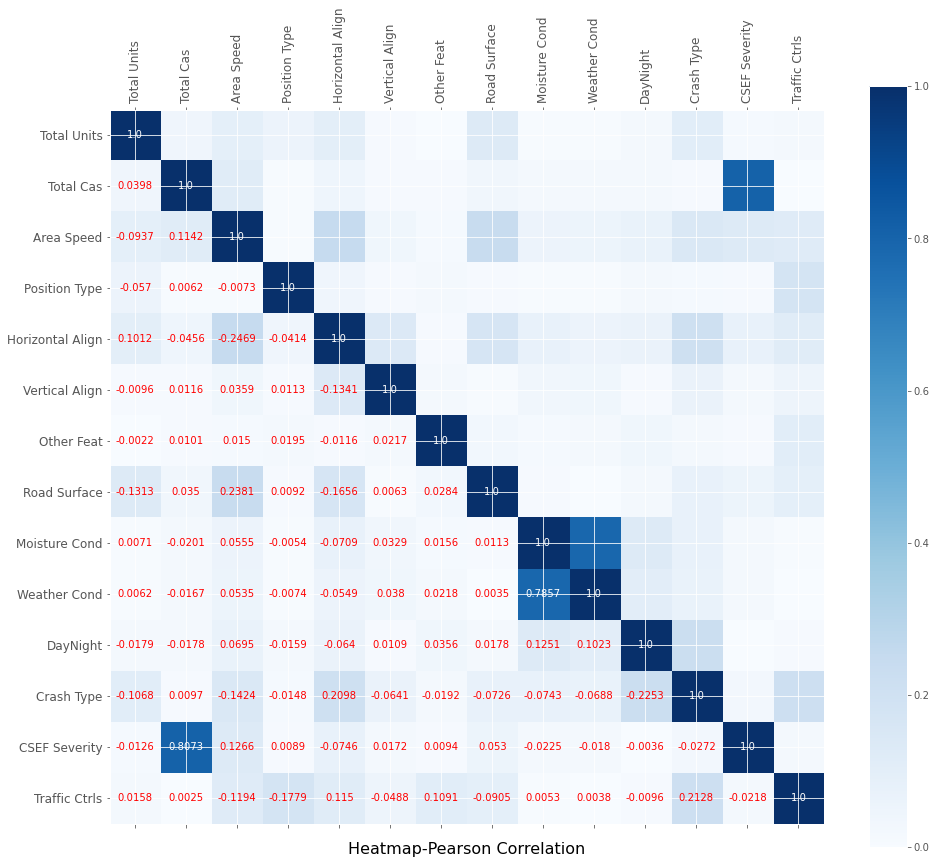

In [110]:
# Corrlation on Heat map 
icount = len(crash_pearson)
fig,ax = plt.subplots(1,1,figsize=(16,14))

# hot bar on right
hot_img = ax.matshow(np.abs(crash_pearson),vmin=0,vmax=1,cmap='Blues')
fig.colorbar(hot_img)

ax.set_title('Heatmap-Pearson Correlation',fontsize=16,pad=-780)
ax.set_xticks(range(0,icount,1))
ax.set_yticks(range(0,icount,1))
ax.set_xticklabels([str(i) for i in crash_pearson.columns],fontsize=12,rotation=90)
ax.set_yticklabels([str(i) for i in crash_pearson.columns],fontsize=12)

# Display values of Correlation in box
for i in range(len(crash_pearson)):
    for j in range(len(crash_pearson)):
        if(j<=i):  # only print half
            if(crash_pearson.values[i, j]>0.7):
                tColor ="w" 
            else:
                tColor ="r"
            text = ax.text(j, i, float("{:.4f}".format(crash_pearson.values[i, j])), 
                           ha="center", va="center", color=tColor)
plt.show()

# 3.4 Save Cleaned Data to CSV

In [111]:
# Cleaned int+Category data 
dfcrash.to_csv('sadata\\DATA_SA_Crash_Cleanned_Category.csv',index=False)
dfcrash.shape

(127672, 14)

In [112]:
# Cleaned original data
dfcrash_org.to_csv('sadata\\DATA_SA_Crash_Cleanned_original.csv',index=False)
dfcrash_org.shape

(127672, 14)

In [113]:
# Load Cleaned int+Category data 
dfcrash = pd.read_csv('sadata\\DATA_SA_Crash_Cleanned_Category.csv')
dfcrash.shape

(127672, 14)

# 4. Pre-Processing

## 4.1 Data Balancing

In [114]:
# Original Data
dfcrash['CSEF Severity'].value_counts()

1    84775
2    37300
3     4875
4      722
Name: CSEF Severity, dtype: int64

In [116]:
# Up-Sampling
# New Dataframe
df_upsampling = pd.DataFrame()

# Upsampling of class 2
df_upsampling = resample(dfcrash[dfcrash['CSEF Severity']==2], replace=True, n_samples=84775, random_state=111)

# Combined with class 1
df_upsampling = pd.concat([df_upsampling, dfcrash[dfcrash['CSEF Severity']==1]])

# Upsampling of class 3
df_sev = resample(dfcrash[dfcrash['CSEF Severity']==3], replace=True, n_samples=84775, random_state=111)

# Combined
df_upsampling = pd.concat([df_upsampling, df_sev])

# Upsampling of calss 4
df_sev = resample(dfcrash[dfcrash['CSEF Severity']==4], replace=True, n_samples=84775, random_state=111)
                           
# Combined
df_upsampling = pd.concat([df_upsampling, df_sev])

print(df_upsampling.shape)

# Display all
df_upsampling['CSEF Severity'].value_counts()


(339100, 14)


4    84775
3    84775
2    84775
1    84775
Name: CSEF Severity, dtype: int64

In [117]:
# Down-Sampling
# New Dataframe
df_dwsampling = pd.DataFrame()

# Upsampling of class 1
df_dwsampling = resample(dfcrash[dfcrash['CSEF Severity']==1], replace=True, n_samples=37300, random_state=111)

# Combined with class 2
df_dwsampling = pd.concat([df_dwsampling, dfcrash[dfcrash['CSEF Severity']==2]])

# Upsampling of class 3
df_sev = resample(dfcrash[dfcrash['CSEF Severity']==3], replace=True, n_samples=37300, random_state=111)

# Combined
df_dwsampling = pd.concat([df_dwsampling, df_sev])

# Upsampling of calss 4
df_sev = resample(dfcrash[dfcrash['CSEF Severity']==4], replace=True, n_samples=37300, random_state=111)
                           
# Combined
df_dwsampling = pd.concat([df_dwsampling, df_sev])

print(df_dwsampling.shape)

# Display all
df_dwsampling['CSEF Severity'].value_counts()

(149200, 14)


4    37300
3    37300
2    37300
1    37300
Name: CSEF Severity, dtype: int64

In [118]:
# Test Data
# New Dataframe
df_tst = pd.DataFrame()
df_tmp = pd.DataFrame()

df_tmp = resample(dfcrash[dfcrash['CSEF Severity']==1], replace=True, n_samples=2000, random_state=111)
df_tst = pd.concat([df_tst, df_tmp])

# Upsampling of class 2
df_tmp = resample(dfcrash[dfcrash['CSEF Severity']==2], replace=True, n_samples=2000, random_state=111)
df_tst = pd.concat([df_tst, df_tmp])

df_tmp = resample(dfcrash[dfcrash['CSEF Severity']==3], replace=True, n_samples=2000, random_state=111)
df_tst = pd.concat([df_tst, df_tmp])

df_tmp = resample(dfcrash[dfcrash['CSEF Severity']==4], replace=True, n_samples=2000, random_state=111)
df_tst = pd.concat([df_tst, df_tmp])

print(df_tst.shape)

# Display all
df_tst['CSEF Severity'].value_counts()

(8000, 14)


3    2000
2    2000
1    2000
4    2000
Name: CSEF Severity, dtype: int64

## 4.2 One hot encoding

In [119]:
col_ohe = {'Area Speed', 'Position Type',
       'Horizontal Align', 'Vertical Align', 'Other Feat', 'Road Surface',
       'Moisture Cond', 'Weather Cond', 'DayNight', 'Crash Type','Traffic Ctrls'}

In [120]:
# Full Data - dfcrash
dfcrash_ohe = pd.get_dummies(dfcrash, columns=col_ohe)

# Save original data to csv
dfcrash_ohe.to_csv('sadata\\DATA_SA_Crash_ohe_original.csv',index=False)
dfcrash_ohe.shape

(127672, 85)

In [121]:
# Down-sampling Data - df_dwsampling
df_dwsampling_ohe = pd.get_dummies(df_dwsampling, columns=col_ohe)

# Save downsampling data to csv
df_dwsampling_ohe.to_csv('sadata\\DATA_SA_Crash_ohe_dwsampling.csv',index=False)
df_dwsampling_ohe.shape

(149200, 85)

In [122]:
# Up-sampling Data - df_upsampling
df_upsampling_ohe = pd.get_dummies(df_upsampling, columns=col_ohe)

# Save upsampling data to csv
df_upsampling_ohe.to_csv('sadata\\DATA_SA_Crash_ohe_upsampling.csv',index=False)
df_upsampling_ohe.shape

(339100, 85)

In [123]:
# Test Data - df_tst
df_tst_ohe = pd.get_dummies(df_tst, columns=col_ohe)

# Save upsampling data to csv
df_tst_ohe.to_csv('sadata\\DATA_SA_Crash_ohe_test.csv',index=False)
df_tst_ohe.shape

(8000, 81)

In [177]:
df_upsampling_ohe.head()

,Total Units,Total Cas,CSEF Severity,Position Type_0,Position Type_1,Position Type_2,Position Type_3,Position Type_4,Position Type_5,Position Type_6,...,Crash Type_6,Crash Type_7,Crash Type_8,Crash Type_9,Crash Type_10,Crash Type_11,Crash Type_12,Moisture Cond_0,Moisture Cond_1,Moisture Cond_2
0,1,2,2,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
1,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,3,1,2,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,2,1,2,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,1,1,2,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0


# Load Data From Here

In [124]:
# Load original data from csv
dfcrash_ohe = pd.read_csv('sadata\\DATA_SA_Crash_ohe_original.csv')
dfcrash_ohe.shape

(127672, 85)

In [125]:
# Load upsampling data from csv
df_upsampling_ohe = pd.read_csv('sadata\\DATA_SA_Crash_ohe_upsampling.csv')
df_upsampling_ohe.shape

(339100, 85)

In [126]:
# Load downsampling data from csv
df_dwsampling_ohe = pd.read_csv('sadata\\DATA_SA_Crash_ohe_dwsampling.csv')
df_dwsampling_ohe.shape

(149200, 85)

In [127]:
# Test Data - df_tst
# Load test data from csv
df_tst_ohe = pd.read_csv('sadata\\DATA_SA_Crash_ohe_test.csv')
df_tst_ohe.shape

(8000, 81)

## 4.3 Normalization & Fit & Transform

In [129]:
# Formal Data - downsampling
y = df_dwsampling_ohe['CSEF Severity']
X = df_dwsampling_ohe.drop('CSEF Severity',axis=1)
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11)
print(X.shape, y.shape)

(149200, 84) (149200,)


In [130]:
# Formal Data - downsampling for DT only
yd = df_dwsampling_ohe['CSEF Severity']
Xd = df_dwsampling_ohe.drop('CSEF Severity',axis=1)

# Split train and test data
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.25, random_state=11)
print(Xd.shape, yd.shape)

(149200, 84) (149200,)


In [131]:
# Formal Data - original
y = dfcrash_ohe['CSEF Severity']
X = dfcrash_ohe.drop('CSEF Severity',axis=1)
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11)
print(X.shape, y.shape)

(127672, 84) (127672,)


In [139]:
# Formal Data - original for DT only
yd = dfcrash_ohe['CSEF Severity']
Xd = dfcrash_ohe.drop('CSEF Severity',axis=1)

# Split train and test data
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.25, random_state=11)
print(Xd.shape, yd.shape)

(127672, 84) (127672,)


In [133]:
# Formal Data - upsampling
y = df_upsampling_ohe['CSEF Severity']
X = df_upsampling_ohe.drop('CSEF Severity',axis=1)
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11)
print(X.shape, y.shape)

(339100, 84) (339100,)


In [134]:
# Partial data for test - reduce execution time
y = df_tst_ohe['CSEF Severity']
X = df_tst_ohe.drop('CSEF Severity',axis=1)
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11)
print(X.shape, y.shape)

(8000, 80) (8000,)


In [135]:
# Partial data for test - reduce execution time for Decision Tree only
yd = df_tst_ohe['CSEF Severity']
Xd = df_tst_ohe.drop('CSEF Severity',axis=1)

# Split train and test data
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.25, random_state=11)
print(Xd.shape, yd.shape)

(8000, 80) (8000,)


# 5. PCA(Principle Component Analysis) and Dimensionality Reduction

In [136]:
# Data for PCA
y = dfcrash_ohe['CSEF Severity']
X = dfcrash_ohe.drop('CSEF Severity',axis=1)
pca = PCA(n_components=59, svd_solver='randomized', random_state=11)
X = pca.fit_transform(X)

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11)
print(X.shape, y.shape)

(127672, 59) (127672,)


In [137]:
print(pca.explained_variance_ratio_)

[0.13 0.1  0.09 0.08 0.06 0.06 0.05 0.05 0.04 0.04 0.03 0.03 0.02 0.02
 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.  ]


In [138]:
sum(pca.explained_variance_ratio_)

0.9992428435249713

# 6. Select the method of cross validation and Optimize model parameter 
Compare randomized search and grid search for optimizing hyperparameters of a linear SVM with SGD training. All parameters that influence the learning are searched simultaneously (except for the number of estimators, which poses a time / quality tradeoff).

The randomized search and the grid search explore exactly the same space of parameters. The result in parameter settings is quite similar, while the run time for randomized search is drastically lower.

The performance is may slightly worse for the randomized search, and is likely due to a noise effect and would not carry over to a held-out test set.

I seleced randomized search as it takes less time.

In [ ]:
# KNN
# specify parameters and distributions to sample from
param_dist = {
    'n_neighbors':[1,5,10,20,30,40,50,60],
    'weights':('uniform','distance'), 
    'algorithm':('auto', 'ball_tree','kd_tree','brute'), 
    'leaf_size':[10,20,30,40,50,60,100],
    'p':[1,2]
}

# Model object
clf = KNeighborsClassifier()

# run randomized search
n_iter_search = 30
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)
random_search.fit(X, y)
report(random_search.cv_results_)

In [ ]:
# DT
# specify parameters and distributions to sample from
param_dist = {
    'criterion':('gini','entropy'),
    'splitter':('best','random'), 
    'max_depth':[10,20,30,50,70,80,90,100,100,200,300,400,500,600], 
    'max_features':('auto','sqrt','log2')
}

# Model Object
clf = DecisionTreeClassifier()

# run randomized search
n_iter_search = 30
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)
random_search.fit(Xd, yd)
report(random_search.cv_results_)

In [ ]:
# SVM
# specify parameters and distributions to sample from
param_dist = {
    'C':[0.001,0.1,1,2,5,10,50,100,],
    'degree':[2,3,4,5],
    'kernel':('rbf','sigmoid'), 
    'gamma':('auto', 'scale')
}

# Model Object
clf = svm.SVC()

# run randomized search
n_iter_search = 30
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)
random_search.fit(X, y)
report(random_search.cv_results_)

In [ ]:
# LR
# specify parameters and distributions to sample from
param_dist = {
    'C':[0.0001,0.001,0.1,1,2,5,10],
    'penalty':('l2','none'),
    'solver':('lbfgs','liblinear','sag','saga')
}

# Model Object
clf = LogisticRegression(max_iter=500)

# run randomized search
n_iter_search = 480
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)
random_search.fit(X, y)
report(random_search.cv_results_)

# 7. Prediction

## 7.1 K-NN

In [140]:
# KNN Model
k = 70
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors=k,
                             weights='distance',
                             p=1,
                             leaf_size=10,
                             algorithm='kd_tree')

In [141]:
# Fit the model according to the given training data.
neigh.fit(X_train,y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=10, n_neighbors=70, p=1,
                     weights='distance')

In [142]:
# Predict class labels for samples in X
knn_yhat = neigh.predict(X_test)
print(X_test.shape)
knn_yhat[0:5]

array([1, 1, 2, 1, 2], dtype=int64)

In [143]:
# Probability estimates.
knn_yhat_proba = neigh.predict_proba(X_test)
knn_yhat_proba

array([[1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.84, 0.13, 0.03],
       ...,
       [1.  , 0.  , 0.  , 0.  ],
       [0.97, 0.03, 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ]])

In [144]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, knn_yhat))

Train set Accuracy:  0.9720011696639305
Test set Accuracy:  0.935522275831819


## 7.2 Decision Trees

In [146]:
# Decision Trees Model
sevTree = DecisionTreeClassifier(criterion="entropy", 
                                 max_depth=90,
                                splitter='best',
                                max_features='sqrt')
sevTree

DecisionTreeClassifier(criterion='entropy', max_depth=90, max_features='sqrt')

In [147]:
# Fit the model according to the given training data.
sevTree.fit(Xd_train,yd_train)

DecisionTreeClassifier(criterion='entropy', max_depth=90, max_features='sqrt')

In [148]:
# Predict class labels for samples in X.
dt_yhat = sevTree.predict(Xd_test)
print(Xd_test.shape)

(31918, 84)


In [149]:
# Probability estimates.
dt_yhat_proba = sevTree.predict_proba(Xd_test)
dt_yhat_proba

array([[1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.84, 0.13, 0.03],
       ...,
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ]])

In [150]:
print("Train set Accuracy: ", metrics.accuracy_score(yd_train, sevTree.predict(Xd_train)))
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(yd_test, dt_yhat))

Train set Accuracy:  0.9720011696639305
DecisionTrees's Accuracy:  0.9383106710946801


## 7.3 SVM (Support Vector Machines)

In [151]:
# SVM Model
sv = svm.SVC(kernel='rbf',
              gamma='scale',
              degree=5, 
              C=10,
              probability=True)

In [152]:
# Fit the model according to the given training data.
sv.fit(X_train, y_train) 

SVC(C=10, degree=5, probability=True)

In [153]:
# Predict class labels for samples in X.
svm_yhat = sv.predict(X_test)
print(X_test.shape)
svm_yhat [0:5]

(31918, 59)


array([1, 1, 2, 1, 2], dtype=int64)

In [154]:
# probabilities of possible outcomes for samples in X_test
# property predict_proba
sv.predict_proba

<bound method BaseSVC._predict_proba of SVC(C=10, degree=5, probability=True)>

In [155]:
sv_yhat_proba = sv.predict_proba(X_test)

In [156]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, sv.predict(X_train)))
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, svm_yhat))

Train set Accuracy:  0.9677820247718111
DecisionTrees's Accuracy:  0.9513127388934144


## 7.4 Logistic Regression

In [157]:
# Logistic Regression with selected parameters
LR = LogisticRegression(C=5,
                        solver='liblinear',
                        penalty='l2') 

LR

LogisticRegression(C=5, solver='liblinear')

In [158]:
# Fit the model according to the given training data.
LR.fit(X_train,y_train)

LogisticRegression(C=5, solver='liblinear')

In [159]:
# Predict class labels for samples in X.
lr_yhat = LR.predict(X_test)
print(X_test.shape)
lr_yhat

(31918, 59)


array([1, 1, 2, ..., 1, 1, 1], dtype=int64)

In [160]:
# Probability estimates
lr_yhat_prob = LR.predict_proba(X_test)
lr_yhat_prob

array([[9.57e-01, 4.04e-02, 2.61e-03, 1.60e-04],
       [9.51e-01, 4.54e-02, 2.86e-03, 2.59e-04],
       [1.39e-04, 9.55e-01, 4.24e-02, 2.98e-03],
       ...,
       [9.64e-01, 2.35e-02, 1.08e-02, 1.29e-03],
       [9.45e-01, 5.03e-02, 4.25e-03, 1.32e-04],
       [9.57e-01, 3.88e-02, 3.63e-03, 3.74e-04]])

In [161]:
y_score_lr = LR.decision_function(X_test)
y_score_lr

array([[ 9.62, -3.12, -5.9 , -8.7 ],
       [ 9.62, -2.99, -5.8 , -8.21],
       [-9.01,  1.64, -3.25, -5.94],
       ...,
       [ 9.5 , -3.69, -4.48, -6.61],
       [ 9.69, -2.88, -5.4 , -8.88],
       [ 9.55, -3.17, -5.57, -7.85]])

In [162]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, LR.predict(X_train)))
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, lr_yhat))

Train set Accuracy:  0.9563778014495478
DecisionTrees's Accuracy:  0.9554170060780751


# 8. Model Evaluation

## 8.1 Confusion Matrix, F1-Score

## 8.1.1 k-nearest neighbors

              precision    recall  f1-score   support

           1       0.97      1.00      0.99     21126
           2       0.87      0.93      0.90      9374
           3       0.23      0.05      0.08      1232
           4       0.26      0.05      0.08       186

    accuracy                           0.94     31918
   macro avg       0.59      0.50      0.51     31918
weighted avg       0.91      0.94      0.92     31918

jaccard_score: [0.97 0.82 0.04 0.04]


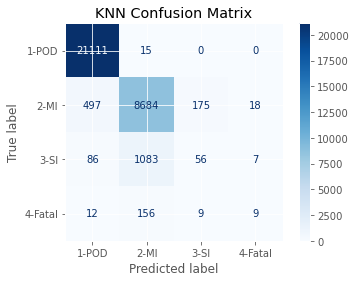

In [163]:
# k-nearest neighbors
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, knn_yhat, labels=[1,2,3,4])
np.set_printoptions(precision=2)

knn_eva = classification_report(y_test, knn_yhat)
print(knn_eva)

#plt.figure()
disp = plot_confusion_matrix(neigh,X_test, y_test,
                      display_labels=['1-POD','2-MI','3-SI','4-Fatal'],
                      cmap=plt.cm.Blues,
                      normalize= None)
tmp = disp.ax_.set_title("KNN Confusion Matrix")
jscore = jaccard_score(y_test, knn_yhat, average=None)
print('jaccard_score:', jscore)

## 8.1.2 Decision Tree

              precision    recall  f1-score   support

           1       0.99      0.99      0.99     21126
           2       0.87      0.94      0.90      9374
           3       0.21      0.08      0.12      1232
           4       0.14      0.06      0.08       186

    accuracy                           0.94     31918
   macro avg       0.55      0.52      0.52     31918
weighted avg       0.92      0.94      0.93     31918

jaccard_score: [0.99 0.83 0.06 0.04]


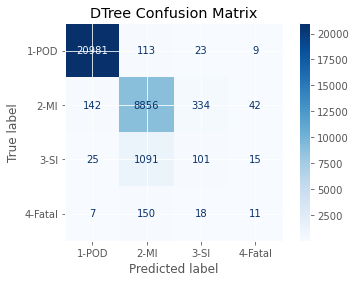

In [164]:
# Decision Tree
# Compute confusion matrix
cnf_matrix = confusion_matrix(yd_test, dt_yhat, labels=[1,2,3,4])
np.set_printoptions(precision=2)

dt_eva = classification_report(yd_test, dt_yhat)
print(dt_eva)

#plt.figure()
disp = plot_confusion_matrix(sevTree,Xd_test, yd_test,
                      display_labels=['1-POD','2-MI','3-SI','4-Fatal'],
                      cmap=plt.cm.Blues,
                      normalize= None)
tmp = disp.ax_.set_title("DTree Confusion Matrix")
jscore = jaccard_score(yd_test, dt_yhat, average=None)
print('jaccard_score:', jscore)

## 8.1.3 SVM

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     21126
           2       0.88      0.98      0.92      9374
           3       0.25      0.06      0.10      1232
           4       0.29      0.06      0.11       186

    accuracy                           0.95     31918
   macro avg       0.61      0.53      0.53     31918
weighted avg       0.93      0.95      0.94     31918

jaccard_score: [1.   0.86 0.05 0.06]


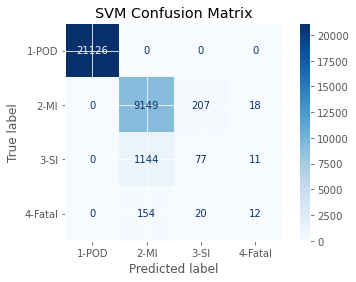

In [165]:
# SVM
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, svm_yhat, labels=[1,2,3,4])
np.set_printoptions(precision=2)

sv_eva = classification_report(y_test, svm_yhat)
print(sv_eva)

#plt.figure()
disp = plot_confusion_matrix(sv,X_test, y_test,
                      display_labels=['1-POD','2-MI','3-SI','4-Fatal'],
                      cmap=plt.cm.Blues,
                      normalize= None)
tmp = disp.ax_.set_title("SVM Confusion Matrix")
jscore = jaccard_score(y_test, svm_yhat, average=None)
print('jaccard_score:', jscore)

## 8.1.4 Logistic Regresson

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     21126
           2       0.87      1.00      0.93      9374
           3       0.08      0.00      0.00      1232
           4       0.50      0.01      0.02       186

    accuracy                           0.96     31918
   macro avg       0.61      0.50      0.49     31918
weighted avg       0.92      0.96      0.94     31918

Log Loss: 0.16423379080294684
jaccard_score: [1.00e+00 8.69e-01 8.05e-04 1.06e-02]


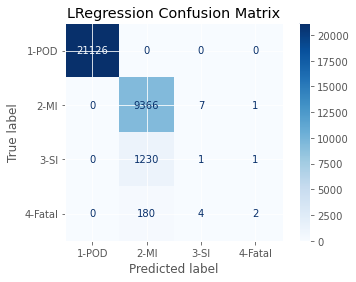

In [181]:
# Logistic Regression
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, lr_yhat, labels=[1,2,3,4])
np.set_printoptions(precision=2)

lr_eva = classification_report(y_test, lr_yhat)
print(lr_eva)

disp = plot_confusion_matrix(LR,X_test, y_test,
                      display_labels=['1-POD','2-MI','3-SI','4-Fatal'],
                      cmap=plt.cm.Blues,
                      normalize= None)
disp.ax_.set_title("LRegression Confusion Matrix")
print('Log Loss:', log_loss(y_test, lr_yhat_prob))
jscore = jaccard_score(y_test, lr_yhat, average=None)
print('jaccard_score:', jscore)

## 8.1.5 Classsification report 

In [167]:
# Classsification report of KNN
dfknn,acc_knn = classification_report_csv(knn_eva)

# Classsification report of DT
dfdt,acc_dt = classification_report_csv(dt_eva)

# Classsification report of SVM
dfsvm,acc_sv = classification_report_csv(sv_eva)

# Classsification report of LR
dflr,acc_lr = classification_report_csv(lr_eva)

## 8.1.6 Comparison of Probability

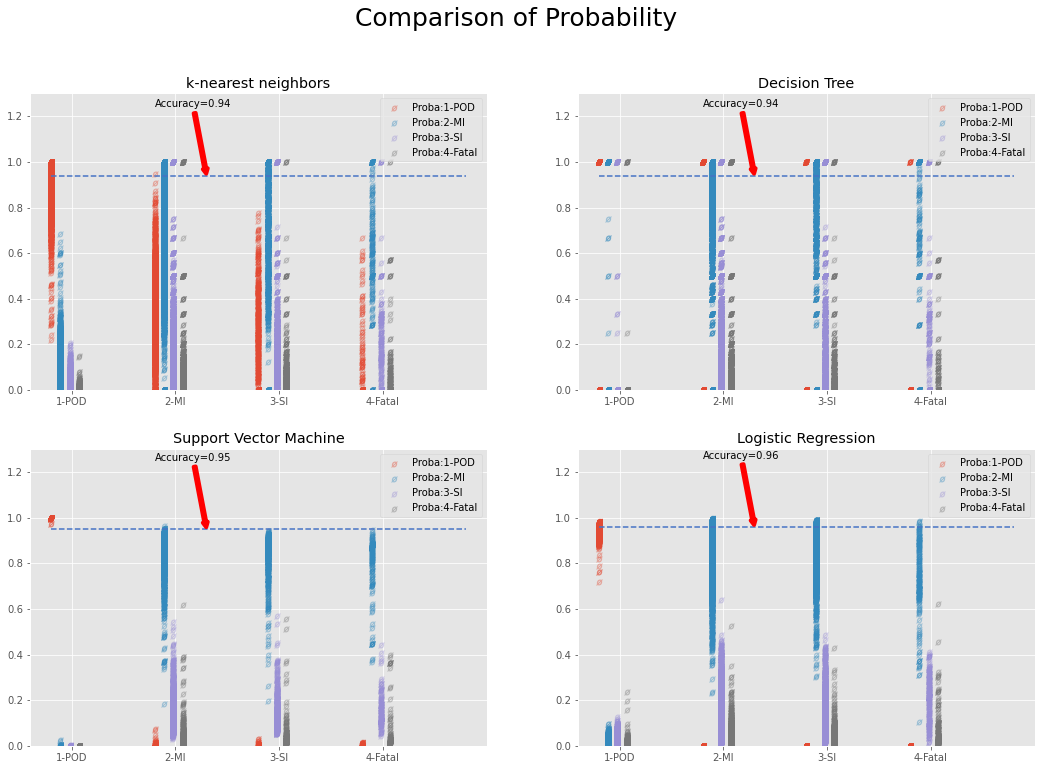

In [173]:
# Generate whole figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,12))
fig.suptitle('Comparison of Probability',fontsize=25)

# subplot KNN
evaluate_prob(ax1,knn_yhat_proba,acc_knn,"k-nearest neighbors")

# subplot DT
evaluate_prob(ax2,dt_yhat_proba,acc_dt,"Decision Tree")

# subplot SVM
evaluate_prob(ax3,sv_yhat_proba,acc_sv,"Support Vector Machine")

# subplot LR
evaluate_prob(ax4,lr_yhat_prob,acc_lr,"Logistic Regression")

plt.show()

# 9. Result

## 9.1 Comparison of precision,recall, f1-score

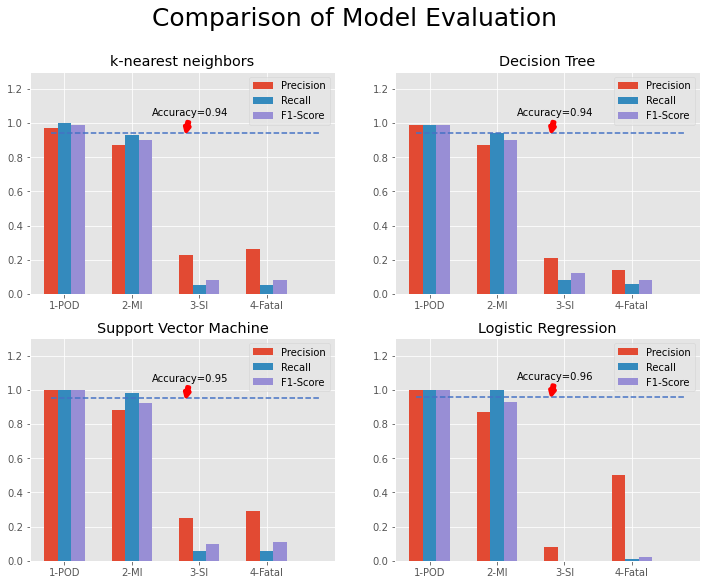

In [176]:
# whole figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(12,9))
fig.suptitle('Comparison of Model Evaluation',fontsize=25)

# subplot KNN
dfknn,acc_knn = classifaction_report_csv(knn_eva)
evaluate_bar(ax1,dfknn,acc_knn,"k-nearest neighbors")

# subplot DT
dfdt,acc_dt = classifaction_report_csv(dt_eva)
evaluate_bar(ax2,dfdt,acc_dt,"Decision Tree")

# subplot SVM
dfsvm,acc_sv = classifaction_report_csv(sv_eva)
evaluate_bar(ax3,dfsvm,acc_sv,"Support Vector Machine")

# subplot LR
dflr,acc_lr = classifaction_report_csv(lr_eva)
evaluate_bar(ax4,dflr,acc_lr,"Logistic Regression")
plt.show()

# 10. Function

In [175]:
# draw bar chart
def evaluate_bar(ax,df,acc,title): # Ax, classification report, accuracy, title
    n_class=['1-POD','2-MI','3-SI','4-Fatal']

    x_1 = list(range(len(n_class)))
    x_2 = [i+0.2 for i in x_1]
    x_3 = [i+0.4 for i in x_1]
    ax.bar(x_1,df['precision'].values,width=0.2)
    ax.bar(x_2,df['recall'].values,width=0.2)
    ax.bar(x_3,df['f1_score'].values,width=0.2)

    ax.legend(['Precision','Recall','F1-Score'],loc='upper right')
    ax.hlines(float(acc),0,len(n_class),linestyles='--',colors='#4472C4')

    ax.set_ylim(0,1.3)
    ax.set_xticks(x_2)
    ax.set_xticklabels(n_class)
    ax.set_title(title)
    ax.annotate('Accuracy='+str(acc),         # s: str. will leave it blank for no text
                 xy=(2, float(acc)),             # place head of the arrow at point 
                 xytext=(1.5,float(acc+0.1)),     # place base of the arrow at point
                 xycoords='data',         # will use the coordinate system of the object being annotated 
                 arrowprops=dict(arrowstyle='simple', connectionstyle='arc3', color='r', lw=4)
                )
    #   plt.show()

In [79]:
# Save report to dataframe
def classification_report_csv(report):  # report string
    report_data = []
    lines = report.split('\n')
    for line in lines[2:6]:                      # only extract Classe 1-4 without name
        row = {}
        row_data = line.split('     ')
        row['class'] = row_data[2]
        row['precision'] = float(row_data[3])
        row['recall'] = float(row_data[4])
        row['f1_score'] = float(row_data[5])
        row['support'] = float(row_data[6])
        report_data.append(row)
    acc=str(lines[7:8]).split()[2]               # extract Accuracy from line 7
    df = pd.DataFrame.from_dict(report_data)
    return df,float(acc)

In [172]:
# draw Scatter chart
def evaluate_prob(ax,proba,acc,title): # Ax, proba result, accuracy, title
    n_class=['1-POD','2-MI','3-SI','4-Fatal']
    n_color=['r','b','g','y']
    x_1 = list(range(len(n_class)))
    x_2 = [i+0.2 for i in x_1]
    
    ax.scatter(y_test-1,proba[:,0],alpha=0.3, marker=r"$\o$")
    ax.scatter(y_test+0.09-1,proba[:,1],alpha=0.3, marker=r"$\o$")
    ax.scatter(y_test+0.09*2-1,proba[:,2],alpha=0.3, marker=r"$\o$")
    ax.scatter(y_test+0.09*3-1,proba[:,3],alpha=0.3, marker=r"$\o$")
    ax.set_ylim(0,1.3)
    ax.set_xticks(x_2)
    ax.set_xticklabels(n_class)
    ax.set_title(title)
    ax.legend(['Proba:1-POD','Proba:2-MI','Proba:3-SI','Proba:4-Fatal'],loc='upper right')
    ax.hlines(float(acc),0,len(n_class),linestyles='--',colors='#4472C4')
    ax.annotate('Accuracy='+str(acc),         # s: str. will leave it blank for no text
                 xy=(1.5, float(acc)),             # place head of the arrow at point 
                 xytext=(1,float(acc+0.3)),     # place base of the arrow at point
                 xycoords='data',         # will use the coordinate system of the object being annotated 
                 arrowprops=dict(arrowstyle='simple', connectionstyle='arc3', color='r', lw=4)
                )
    

In [81]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")